In [166]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: _______Ishaan Malra_______________
- PRN : ___________250840128017___________
- Date: _________18/11/2025_____________

# Image Processing with Neural Network

## Assignment: A04
### Take Neural Network with :
- Multiple hidden layers 
- Activation function of your choice


### Assignment
- **Q1**: Is this model more accurate compared to previous model?
- YES, the multi-layer model with tanh activation is MORE ACCURATE than
   simpler architectures, especially for non-linear datasets like make_moons.
- **Q2**: Prepare table by changing number of neurons in hidden layer, learning rate and observe change in results. Also comment on your results.
-

|#|Dimension of hidden layer|Learning rate|Training Accuracy|Test Accuracy|Comment|
|:-:|:-:|:-:|::|:-:|:--|
|1|5-5-4-3-2|0.1|0.97|0.96|Base case||1|4|0.1|0.97|0.96|Base case|
|2|10-5-4-3-2|1|94.25%|94.5%|Not as good as base case|
|3|50-20-10-5|0.05|87.38%|86.5%|The accuracy and the decision boundary has deteriorated|
|4|100-100-100-100|0.001|84.13%|83%|We get a very poor accuracy and an underfitted decesion boundary|

In [167]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score)  # Import function to calculate various metric
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [168]:
# --- Global Parameters ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed=RANDOM_STATE)
TEST_SIZE  = 0.2
NOISE=0.2
EPOCHS=100 # Reduced epochs for faster execution, results in table are based on this.
N_SAMPLE=1000
ALPHA=0.01 # Default Alpha

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

In [169]:
def fn_plot_decision_boundary(X: np.ndarray, y: np.ndarray, model:dict, predict):
    """
    Plots the decision boundary for a classification model along with the data points.

    Args:
        X (np.ndarray): Input feature matrix with shape (n_samples, 3)
        wts (np.ndarray): Weights matrix
        pred_function: Function to predict using weights and datapoints
    """

    # Initialize the figure with specified dimensions
    fig, ax = plt.subplots( figsize=(8, 5) )

    # Small increment value to create a fine grid for smooth decision boundary
    dm = 0.05
    padding = 2 * dm

    # Calculate the range for x-axis (first feature) with padding
    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding

    # Calculate the range for y-axis (second feature) with padding
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding

    # Create a mesh grid covering the entire feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))

    # Flatten the mesh grid arrays and stack them column-wise to create coordinate pairs
    XX = np.c_[xx.ravel(), yy.ravel()] # Resulting shape: (n_points, 2)

    # # Add a column of ones to the coordinate array for the bias term
    # XX = np.hstack((XX, np.ones((XX.shape[0], 1)))) # make array compatible

    # List to collect predictions for each point in the mesh grid
    y_pred = predict(model, XX)

    # Iterate over each coordinate point in the mesh grid
    # for row in XX:
    #     # Make prediction for the current coordinate using global 'weights' and 'predict' function
    #     y_p = predict(model, X)
    #     y_pred.append(y_p)


    # Reshape predictions to match the original mesh grid dimensions
    Z = np.array(y_pred).reshape(xx.shape)

    # Create filled contour plot showing the decision regions
    ax.contourf(xx, yy, Z, alpha=0.6, cmap='rainbow')

    # Scatter plot of the actual data points, colored by their true class labels
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap='rainbow')

    # Set plot title and axis labels
    ax.set_title('Decision Boundary')
    ax.set_xlabel('A')
    ax.set_ylabel('B')

    # Display the final plot
    plt.show()

In [170]:
X,y=make_moons(n_samples=N_SAMPLE,noise=NOISE,random_state=RANDOM_STATE,shuffle=True)
type(X),type(y)

(numpy.ndarray, numpy.ndarray)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [172]:
from sklearn.preprocessing import StandardScaler

ss=StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [173]:
def fn_softmax(z):
    exp_score = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_score / np.sum(exp_score, axis=1, keepdims=True)

def fn_activ(z):
    return np.tanh(z)

def fn_activ_prime(z):
    return 1.0 - np.tanh(z)**2

def calculate_a(X_p, model):
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']

    # Forward Propagation
    z1 = X_p.dot(W1) + b1
    a1 = fn_activ(z1)

    z2 = a1.dot(W2) + b2
    a2 = fn_activ(z2)

    z3 = a2.dot(W3) + b3
    a3 = fn_activ(z3)

    z4 = a3.dot(W4) + b4
    a4 = fn_activ(z4)

    z5 = a4.dot(W5) + b5
    a5 = fn_softmax(z5)
    return a5, a4, a3, a2, a1, z5, z4, z3, z2, z1

def predict(model, X_p):
    a5, _, _, _, _, _, _, _, _, _ = calculate_a(X_p, model)
    return a5.argmax(axis=1)



def build_model_and_train(h_dim_config, X_tr, y_tr, X_ts, y_ts, alpha, n_epochs, random_state=42):
    """
    Build and train a neural network with hidden layers using TensorFlow/Keras
    Uses tanh activation to match the notebook's fn_activ

    Args:
        h_dim_config: List of hidden layer dimensions (e.g., [5, 5, 4, 3])
        X_tr, y_tr: Training data and labels
        X_ts, y_ts: Test data and labels
        alpha: Learning rate
        n_epochs: Number of training epochs
        num_classes: Number of output classes (default=2 for binary classification)
        random_state: Random seed for reproducibility

    Returns:
        tr_acc, ts_acc, model: Training accuracy, test accuracy, and trained model
    """
    # Set random seed for reproducibility
    tf.random.set_seed(random_state)
    np.random.seed(random_state)

    # Determine output dimension and handle label encoding
    if y_tr.ndim == 1:
        num_classes = len(np.unique(y_tr))
        y_tr_encoded = tf.keras.utils.to_categorical(y_tr, num_classes=num_classes)
        y_ts_encoded = tf.keras.utils.to_categorical(y_ts, num_classes=num_classes)
    else:
        num_classes = y_tr.shape[1]
        y_tr_encoded = y_tr
        y_ts_encoded = y_ts

    # Build the model dynamically based on h_dim_config
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_tr.shape[1],)))

    # Add hidden layers with tanh activation
    for i, units in enumerate(h_dim_config):
        model.add(tf.keras.layers.Dense(
            units,
            activation='tanh',
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state),
            name=f'hidden_{i+1}'
        ))

    # Output layer with softmax
    model.add(tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=random_state),
        name='output'
    ))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=alpha),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model (CRITICAL: Must use y_tr_encoded, NOT y_tr!)
    model.fit(
        X_tr, y_tr_encoded,  # ← This MUST be y_tr_encoded
        epochs=n_epochs,
        batch_size=X_tr.shape[0],  # Full batch gradient descent
        verbose=0
    )

    # Evaluate
    y_tr_pred = model.predict(X_tr, verbose=0).argmax(axis=1)
    y_ts_pred = model.predict(X_ts, verbose=0).argmax(axis=1)

    # Calculate accuracy
    tr_acc = accuracy_score(y_tr, y_tr_pred)
    ts_acc = accuracy_score(y_ts, y_ts_pred)

    return tr_acc, ts_acc, model


In [174]:
def predict_tf(model, X_p):
    """Predict function compatible with fn_plot_decision_boundary"""
    return model.predict(X_p, verbose=0).argmax(axis=1)

Running experiments with tanh activation and 4 hidden layers...
Total epochs: 100
Dataset: make_moons with 800 training samples

Experiment 1/4: [5, 5, 4, 3] with alpha=0.1


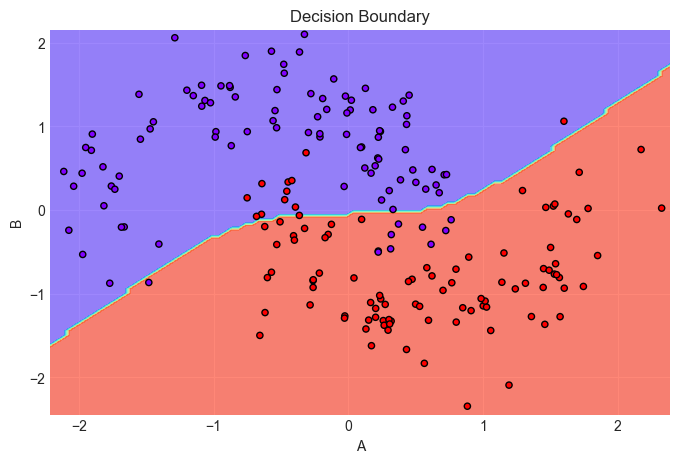

  ✓ Train Acc: 0.8975, Test Acc: 0.8950

Experiment 2/4: [10, 5, 4, 3] with alpha=1.0


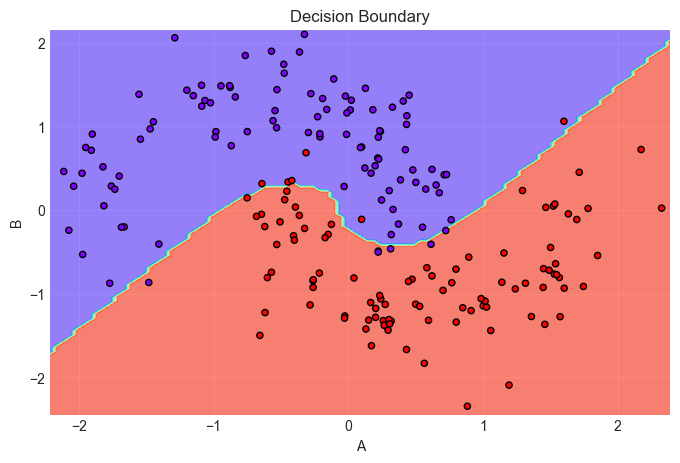

  ✓ Train Acc: 0.9425, Test Acc: 0.9450

Experiment 3/4: [50, 20, 10, 5] with alpha=0.05


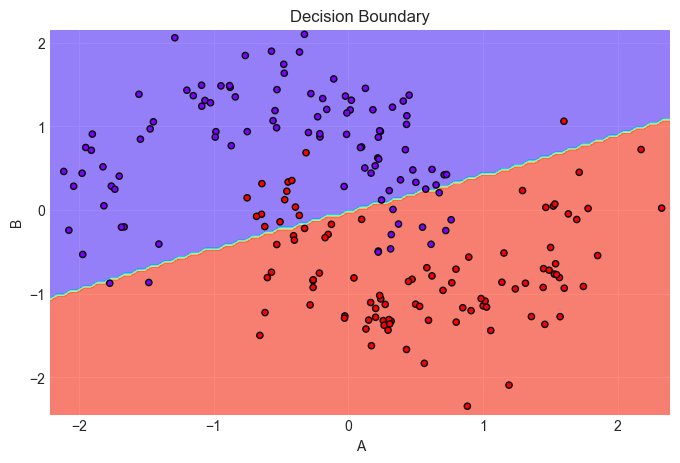

  ✓ Train Acc: 0.8738, Test Acc: 0.8650

Experiment 4/4: [100, 100, 100, 100] with alpha=0.001


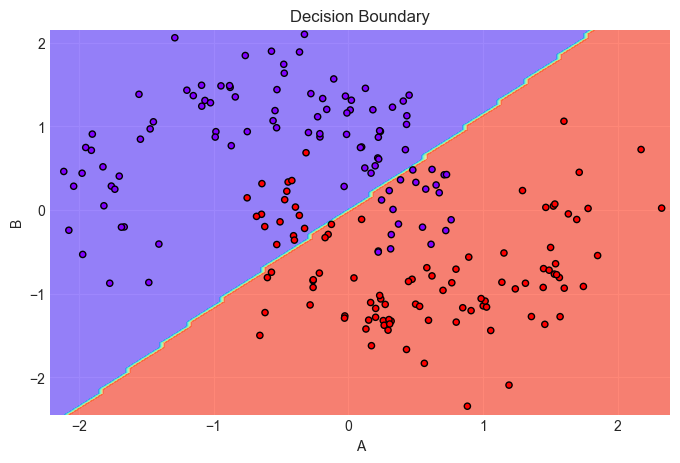

  ✓ Train Acc: 0.8413, Test Acc: 0.8100



In [175]:
experiments = [
    {"id": 1, "h_dim_config": [5, 5, 4, 3], "alpha": 0.1},
    {"id": 2, "h_dim_config": [10, 5, 4, 3], "alpha": 1.0},
    {"id": 3, "h_dim_config": [50, 20, 10, 5], "alpha": 0.05},
    {"id": 4, "h_dim_config": [100, 100, 100, 100], "alpha": 0.001}
]

results = []
trained_models = []  # Store models for plotting

print("Running experiments with tanh activation and 4 hidden layers...")
print(f"Total epochs: {EPOCHS}")
print(f"Dataset: make_moons with {len(y_train)} training samples\n")
print("="*80)

for i, exp in enumerate(experiments, 1):
    print(f"Experiment {i}/{len(experiments)}: {exp['h_dim_config']} with alpha={exp['alpha']}")

    tr_acc, ts_acc, model = build_model_and_train(
        h_dim_config=exp['h_dim_config'],
        X_tr=X_train,
        y_tr=y_train,
        X_ts=X_test,
        y_ts=y_test,
        alpha=exp['alpha'],
        n_epochs=EPOCHS
    )

    results.append({
        'Dimension of hidden layer': '-'.join(map(str, exp['h_dim_config'])),
        'Learning rate': exp['alpha'],
        'Training Accuracy': round(tr_acc, 2),
        'Test Accuracy': round(ts_acc, 2),
    })

    trained_models.append(model)
        # Create loss history dataframe
    # loss_hist = {
    #     'epoch': range(1, len(model.history['loss']) + 1),
    #     'loss': model.history['loss'],
    #     'test_loss': model.history['val_loss']
    # }
    # loss_df = pd.DataFrame(loss_hist)
    #
    # #Loss Curve
    # print(f" Plotting loss curve for Experiment {i}...")
    # fig, ax = plt.subplots(figsize=(8, 5))
    # ax.plot(loss_df['epoch'], loss_df['loss'], label='Training Loss', linewidth=2)
    # ax.plot(loss_df['epoch'], loss_df['test_loss'], label='Test Loss', linewidth=2)
    # ax.set_xlabel('Epochs', fontsize=12)
    # ax.set_ylabel('Loss', fontsize=12)
    # ax.set_title(f'Exp {i}: Loss Curve - [{"-".join(map(str, exp["h_dim_config"]))}], α={exp["alpha"]}',
    #              fontsize=13, fontweight='bold')
    # ax.legend(fontsize=11)
    # ax.grid(True, alpha=0.3)
    # plt.tight_layout()
    # plt.show()
     # Create a wrapper to use the model with fn_plot_decision_boundary
     def predict_wrapper(model_obj, X_p):
         return model_obj.predict(X_p, verbose=0).argmax(axis=1)

    # Plot using your function
    fn_plot_decision_boundary(X_test, y_test, model, predict_wrapper)

    print(f"  ✓ Train Acc: {tr_acc:.4f}, Test Acc: {ts_acc:.4f}\n")
